In [ ]:
!pip install wandb

In [2]:
import wandb

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nipkha21 (nipkha21-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
import seaborn as sns

In [8]:
plt.style.use('seaborn-v0_8')

In [9]:
sns.set_palette("husl")

In [10]:
wandb.init(
    project="facial-expression-recognition",
    group="Data_Exploration",
    name="data_analysis_2024",
    config={
        "dataset": "FER2013",
        "task": "facial_expression_classification",
        "num_classes": 7,
        "image_size": "48x48",
        "color": "grayscale"
    }
)

In [11]:
from google.colab import files

In [14]:
uploaded = files.upload()

Saving train.csv to train.csv


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
original_train_path = 'drive/MyDrive/train.csv'
original_df = pd.read_csv(original_train_path)

In [17]:
original_df.shape

(28709, 2)

In [18]:
original_df.columns

Index(['emotion', 'pixels'], dtype='object')

In [19]:
original_df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [23]:
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

emotion_map = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
    4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}


train_val_df, test_df = train_test_split(
    original_df,
    test_size=TEST_RATIO,
    stratify=original_df['emotion'],
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=VAL_RATIO / (TRAIN_RATIO + VAL_RATIO),
    stratify=train_val_df['emotion'],
    random_state=42
)

print(f"  Training set: {len(train_df):,} samples ({len(train_df)/len(original_df):.1%})")
print(f"  Validation set: {len(val_df):,} samples ({len(val_df)/len(original_df):.1%})")
print(f"  Test set: {len(test_df):,} samples ({len(test_df)/len(original_df):.1%})")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df):,} samples")

  Training set: 20,095 samples (70.0%)
  Validation set: 4,307 samples (15.0%)
  Test set: 4,307 samples (15.0%)
  Total: 28,709 samples


In [24]:
import os
os.makedirs('data', exist_ok=True)
train_df.to_csv('data/train_split.csv', index=False)
val_df.to_csv('data/val_split.csv', index=False)
test_df.to_csv('data/test_split.csv', index=False)

In [25]:
split_metadata = {
    'original_size': len(original_df),
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'split_ratios': {
        'train': TRAIN_RATIO,
        'val': VAL_RATIO,
        'test': TEST_RATIO
    },
    'random_state': 42,
    'stratified': True
}

In [26]:
import json
with open('data/split_metadata.json', 'w') as f:
    json.dump(split_metadata, f, indent=2)

In [28]:
splits_analysis = {}

for split_name, split_df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    print(f"\n--- {split_name} Split Analysis ---")

    class_counts = split_df['emotion'].value_counts().sort_index()

    sample_size = min(500, len(split_df))
    sample_pixels = []

    for i in range(sample_size):
        pixels = np.array([int(p) for p in split_df.iloc[i]['pixels'].split()])
        sample_pixels.extend(pixels)

    sample_pixels = np.array(sample_pixels)

    splits_analysis[split_name] = {
        'size': len(split_df),
        'class_distribution': class_counts.to_dict(),
        'pixel_stats': {
            'mean': float(np.mean(sample_pixels)),
            'std': float(np.std(sample_pixels)),
            'min': float(np.min(sample_pixels)),
            'max': float(np.max(sample_pixels))
        }
    }

    print(f"Size: {len(split_df):,} samples")
    print(f"Pixel stats - Mean: {splits_analysis[split_name]['pixel_stats']['mean']:.1f}, "
          f"Std: {splits_analysis[split_name]['pixel_stats']['std']:.1f}")


--- Train Split Analysis ---
Size: 20,095 samples
Pixel stats - Mean: 127.5, Std: 65.2

--- Validation Split Analysis ---
Size: 4,307 samples
Pixel stats - Mean: 127.2, Std: 65.1

--- Test Split Analysis ---
Size: 4,307 samples
Pixel stats - Mean: 131.6, Std: 65.2


In [30]:
for split_name, analysis in splits_analysis.items():
    class_counts = list(analysis['class_distribution'].values())
    imbalance_ratio = max(class_counts) / min(class_counts)
    analysis['imbalance_ratio'] = imbalance_ratio

    if imbalance_ratio > 2:
        print(f"{split_name}: Significant class imbalance (ratio: {imbalance_ratio:.2f})")
    else:
        print(f"{split_name}: Classes relatively balanced (ratio: {imbalance_ratio:.2f})")

Train: Significant class imbalance (ratio: 16.51)
Validation: Significant class imbalance (ratio: 16.65)
Test: Significant class imbalance (ratio: 16.65)


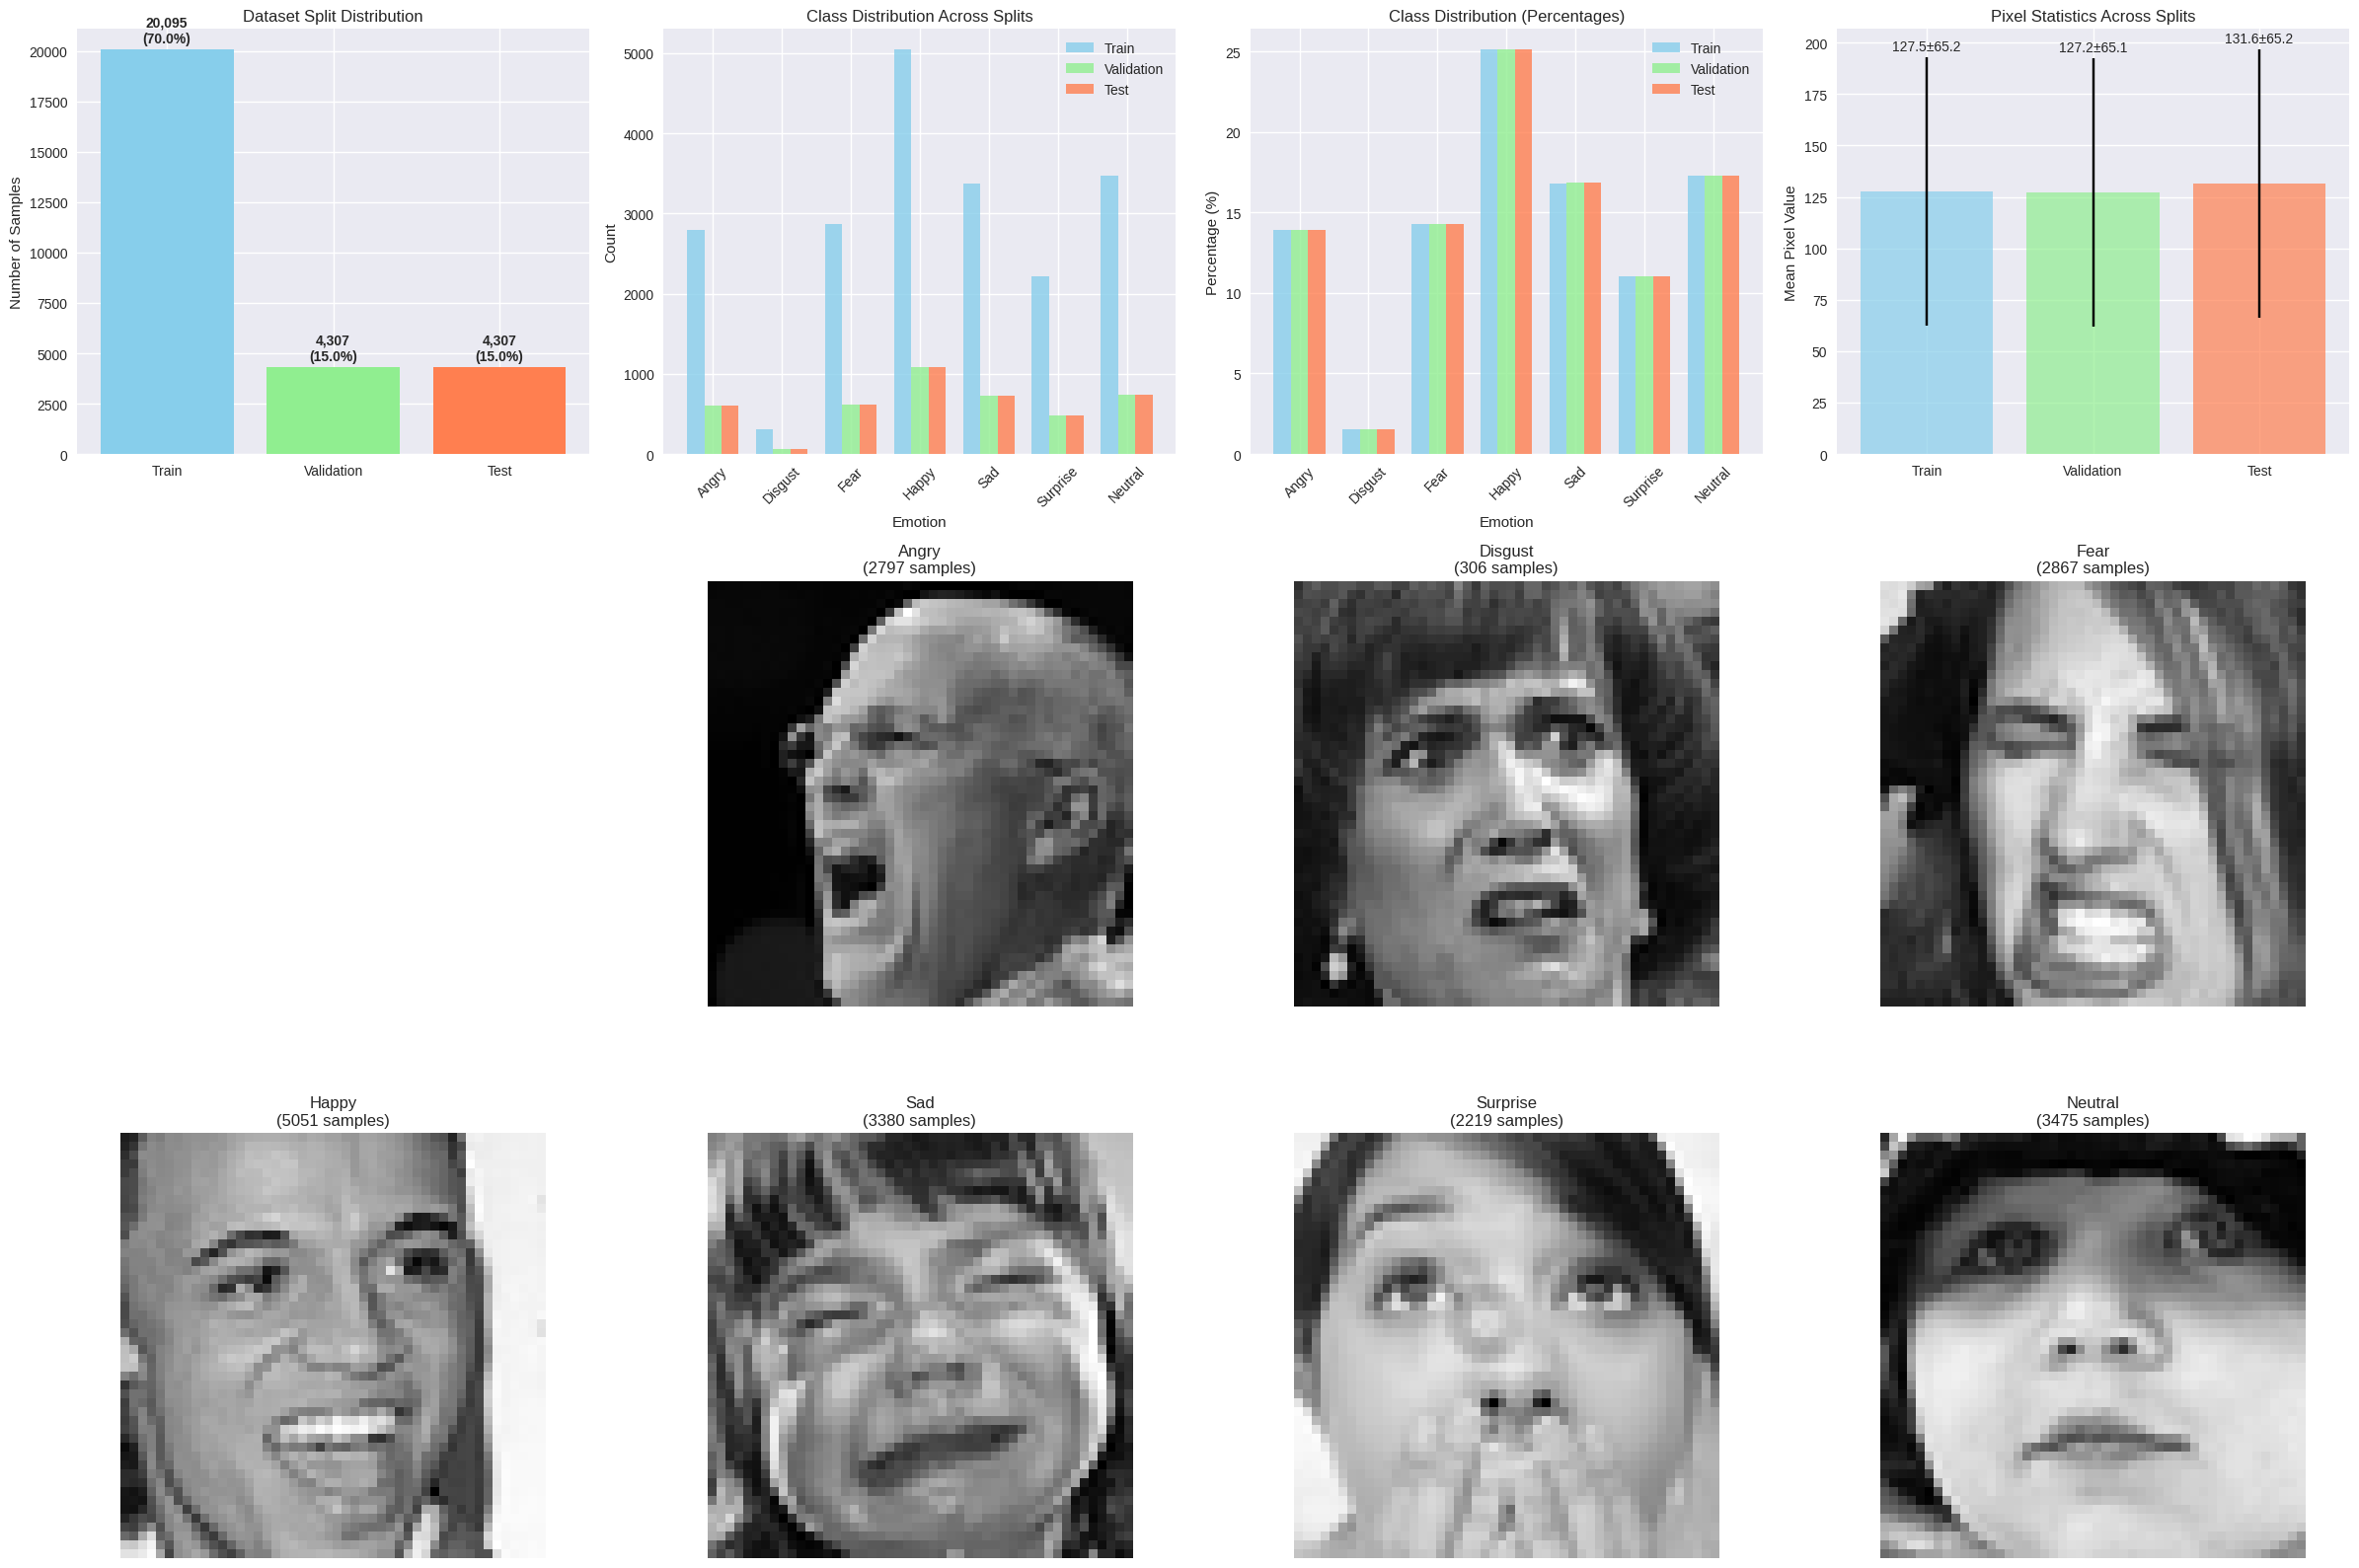

In [31]:
fig = plt.figure(figsize=(24, 16))

ax1 = plt.subplot(3, 4, 1)
split_sizes = [len(train_df), len(val_df), len(test_df)]
split_labels = ['Train', 'Validation', 'Test']
colors = ['skyblue', 'lightgreen', 'coral']

bars = ax1.bar(split_labels, split_sizes, color=colors)
ax1.set_title('Dataset Split Distribution')
ax1.set_ylabel('Number of Samples')

for bar, size in zip(bars, split_sizes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
            f'{size:,}\n({size/len(original_df):.1%})',
            ha='center', va='bottom', fontweight='bold')

ax2 = plt.subplot(3, 4, 2)
emotions = list(emotion_map.keys())
train_counts = [splits_analysis['Train']['class_distribution'][e] for e in emotions]
val_counts = [splits_analysis['Validation']['class_distribution'][e] for e in emotions]
test_counts = [splits_analysis['Test']['class_distribution'][e] for e in emotions]

x = np.arange(len(emotions))
width = 0.25

ax2.bar(x - width, train_counts, width, label='Train', color='skyblue', alpha=0.8)
ax2.bar(x, val_counts, width, label='Validation', color='lightgreen', alpha=0.8)
ax2.bar(x + width, test_counts, width, label='Test', color='coral', alpha=0.8)

ax2.set_xlabel('Emotion')
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution Across Splits')
ax2.set_xticks(x)
ax2.set_xticklabels([emotion_map[e] for e in emotions], rotation=45)
ax2.legend()


ax3 = plt.subplot(3, 4, 3)
train_percentages = np.array(train_counts) / len(train_df) * 100
val_percentages = np.array(val_counts) / len(val_df) * 100
test_percentages = np.array(test_counts) / len(test_df) * 100

ax3.bar(x - width, train_percentages, width, label='Train', color='skyblue', alpha=0.8)
ax3.bar(x, val_percentages, width, label='Validation', color='lightgreen', alpha=0.8)
ax3.bar(x + width, test_percentages, width, label='Test', color='coral', alpha=0.8)

ax3.set_xlabel('Emotion')
ax3.set_ylabel('Percentage (%)')
ax3.set_title('Class Distribution (Percentages)')
ax3.set_xticks(x)
ax3.set_xticklabels([emotion_map[e] for e in emotions], rotation=45)
ax3.legend()


ax4 = plt.subplot(3, 4, 4)
pixel_means = [splits_analysis[split]['pixel_stats']['mean'] for split in ['Train', 'Validation', 'Test']]
pixel_stds = [splits_analysis[split]['pixel_stats']['std'] for split in ['Train', 'Validation', 'Test']]

bars = ax4.bar(split_labels, pixel_means, yerr=pixel_stds, color=colors, alpha=0.7, capsize=5)
ax4.set_title('Pixel Statistics Across Splits')
ax4.set_ylabel('Mean Pixel Value')

for bar, mean, std in zip(bars, pixel_means, pixel_stds):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 2,
            f'{mean:.1f}±{std:.1f}', ha='center', va='bottom')


sample_positions = [(1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]

for emotion in range(7):
    row, col = sample_positions[emotion]
    ax = plt.subplot(3, 4, row * 4 + col + 1)

    emotion_samples = train_df[train_df['emotion'] == emotion]
    if len(emotion_samples) > 0:
        sample_idx = np.random.randint(0, len(emotion_samples))
        pixels = emotion_samples.iloc[sample_idx]['pixels']
        image = np.array([int(p) for p in pixels.split()]).reshape(48, 48)

        ax.imshow(image, cmap='gray')
        ax.set_title(f'{emotion_map[emotion]}\n({len(emotion_samples)} samples)')
        ax.axis('off')

plt.tight_layout()
plt.savefig('comprehensive_data_analysis_with_splits.png', dpi=300, bbox_inches='tight')
plt.show()

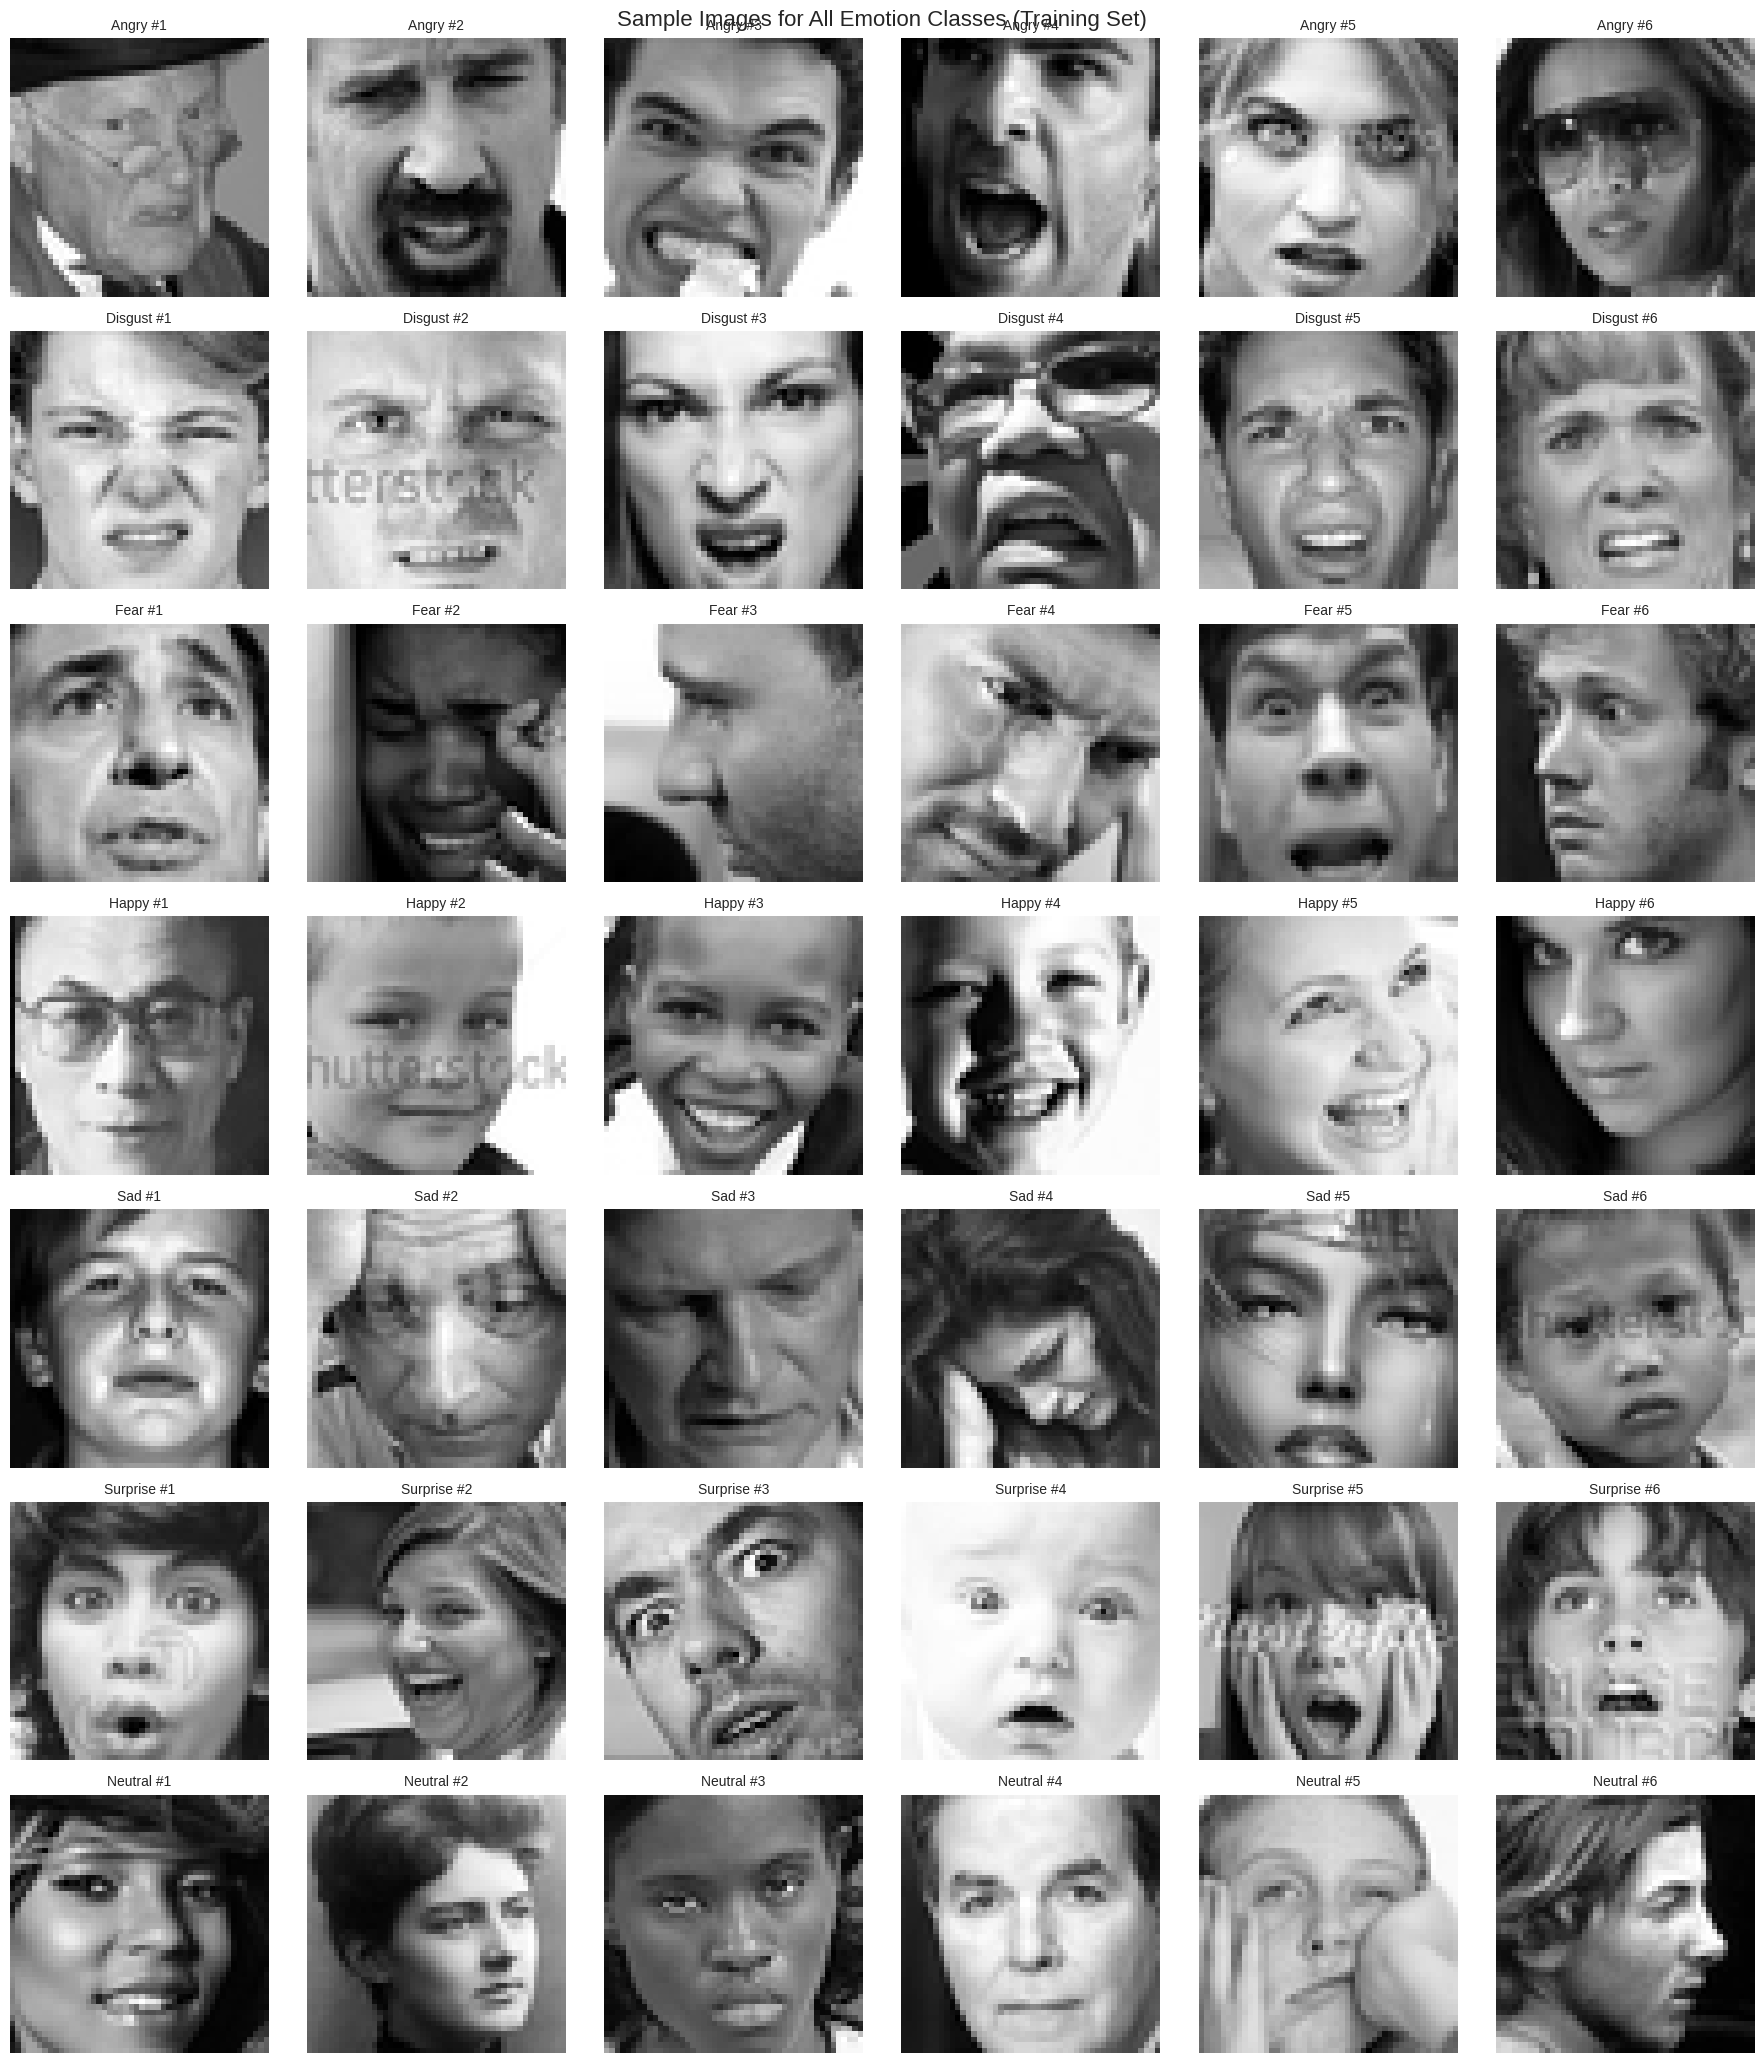

In [32]:
fig, axes = plt.subplots(7, 6, figsize=(18, 21))

for emotion in range(7):
    emotion_data = train_df[train_df['emotion'] == emotion]

    num_samples = min(6, len(emotion_data))
    if num_samples > 0:
        sample_indices = np.random.choice(len(emotion_data), num_samples, replace=False)

        for i in range(6):
            ax = axes[emotion, i]

            if i < num_samples:
                pixels = emotion_data.iloc[sample_indices[i]]['pixels']
                image = np.array([int(p) for p in pixels.split()]).reshape(48, 48)
                ax.imshow(image, cmap='gray')
                ax.set_title(f'{emotion_map[emotion]} #{i+1}', fontsize=10)
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{emotion_map[emotion]} #{i+1}', fontsize=10)

            ax.axis('off')

plt.suptitle('Sample Images for All Emotion Classes (Training Set)', fontsize=16, y=0.98)
plt.tight_layout()
plt.savefig('detailed_sample_images_by_emotion.png', dpi=300, bbox_inches='tight')
plt.show()


<ipython-input-33-51adfdcd3f8e>:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(split_means, labels=['Train', 'Val', 'Test'])


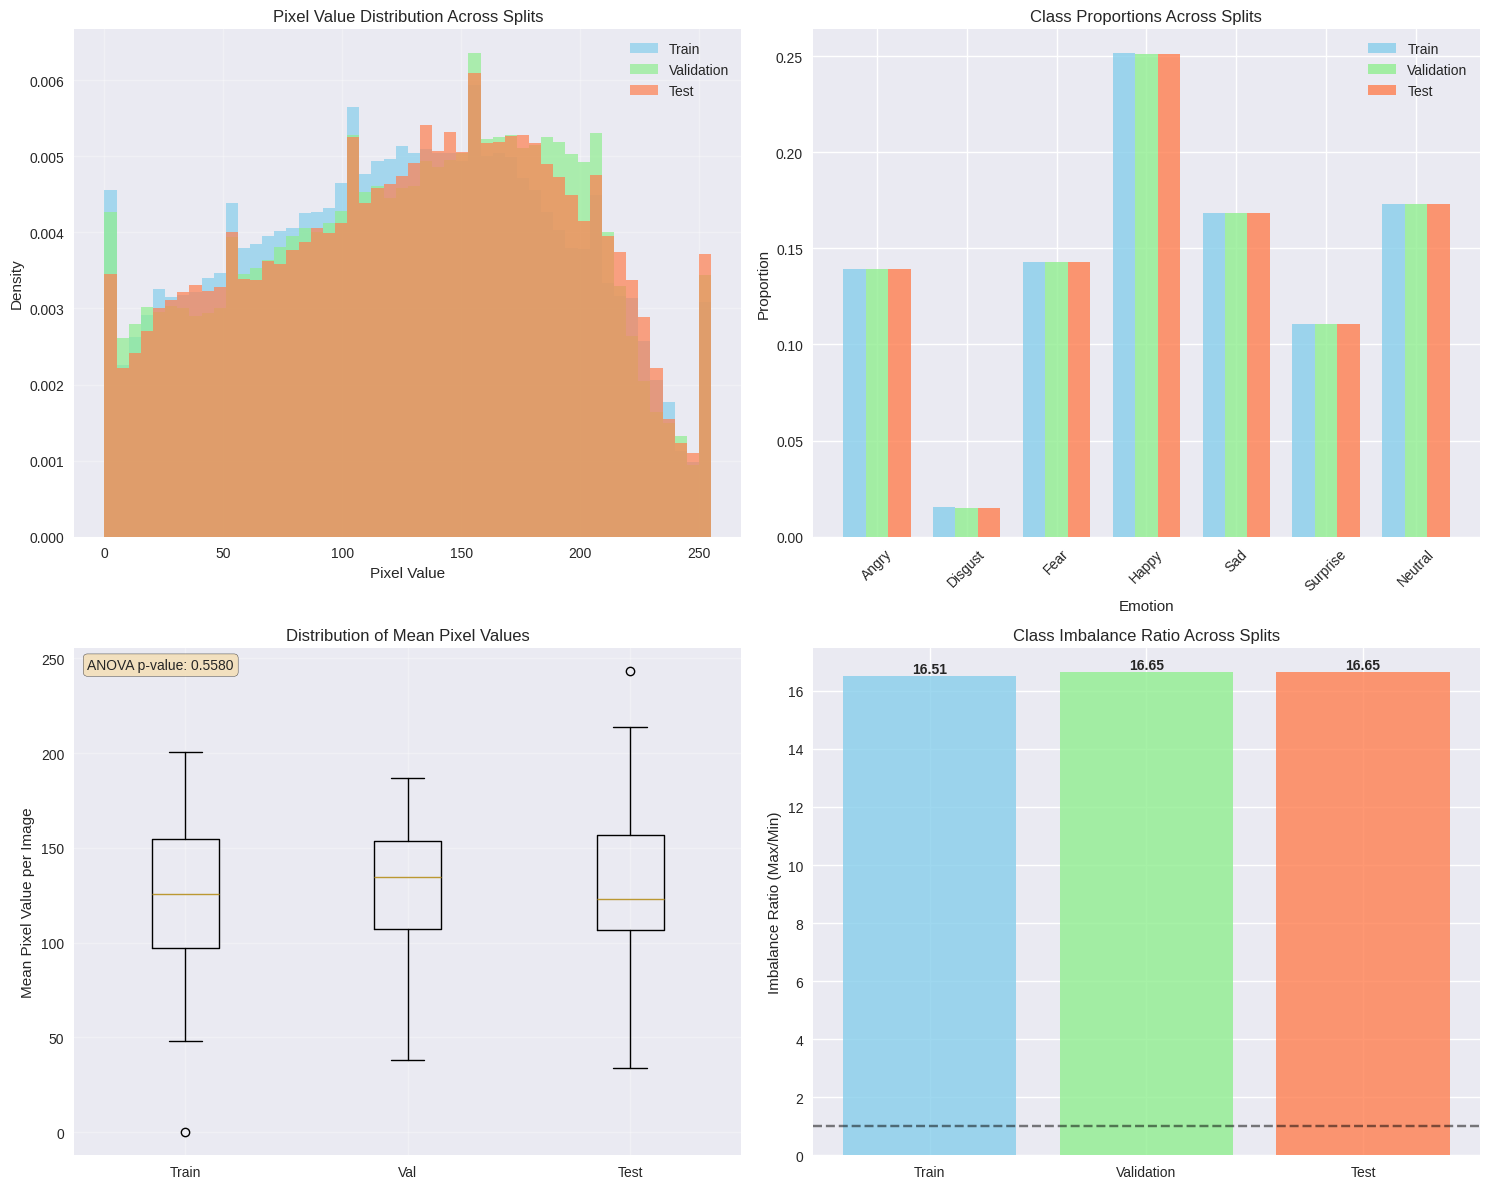


=== STATISTICAL CONSISTENCY TESTS ===
ANOVA test for mean pixel values across splits:
  F-statistic: 0.5846
  P-value: 0.5580
  ✅ No significant difference in pixel distributions across splits

Chi-square test for class distribution consistency:
  Chi-square statistic: 0.0101
  P-value: 1.0000
  Degrees of freedom: 12
Class distributions are consistent across splits


In [33]:
def pixels_to_image(pixels_string):
    pixels = [int(p) for p in pixels_string.split()]
    return np.array(pixels).reshape(48, 48)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))


colors = ['skyblue', 'lightgreen', 'coral']
for i, (split_name, split_df) in enumerate([("Train", train_df), ("Validation", val_df), ("Test", test_df)]):
    sample_pixels = []
    sample_size = min(200, len(split_df))

    for j in range(sample_size):
        pixels = np.array([int(p) for p in split_df.iloc[j]['pixels'].split()])
        sample_pixels.extend(pixels)

    axes[0, 0].hist(sample_pixels, bins=50, alpha=0.7, label=split_name,
                   color=colors[i], density=True)

axes[0, 0].set_title('Pixel Value Distribution Across Splits')
axes[0, 0].set_xlabel('Pixel Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

emotions_list = list(emotion_map.keys())
train_props = np.array([splits_analysis['Train']['class_distribution'][e] for e in emotions_list]) / len(train_df)
val_props = np.array([splits_analysis['Validation']['class_distribution'][e] for e in emotions_list]) / len(val_df)
test_props = np.array([splits_analysis['Test']['class_distribution'][e] for e in emotions_list]) / len(test_df)

x = np.arange(len(emotions_list))
width = 0.25

axes[0, 1].bar(x - width, train_props, width, label='Train', color='skyblue', alpha=0.8)
axes[0, 1].bar(x, val_props, width, label='Validation', color='lightgreen', alpha=0.8)
axes[0, 1].bar(x + width, test_props, width, label='Test', color='coral', alpha=0.8)

axes[0, 1].set_xlabel('Emotion')
axes[0, 1].set_ylabel('Proportion')
axes[0, 1].set_title('Class Proportions Across Splits')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([emotion_map[e] for e in emotions_list], rotation=45)
axes[0, 1].legend()

from scipy import stats

split_means = []
split_stds = []

for split_name, split_df in [("Train", train_df), ("Validation", val_df), ("Test", test_df)]:
    sample_images = []
    sample_size = min(100, len(split_df))

    for i in range(sample_size):
        image = pixels_to_image(split_df.iloc[i]['pixels'])
        sample_images.append(image.mean())

    split_means.append(sample_images)
    split_stds.append(np.std(sample_images))

axes[1, 0].boxplot(split_means, labels=['Train', 'Val', 'Test'])
axes[1, 0].set_title('Distribution of Mean Pixel Values')
axes[1, 0].set_ylabel('Mean Pixel Value per Image')
axes[1, 0].grid(True, alpha=0.3)

f_stat, p_value = stats.f_oneway(*split_means)
axes[1, 0].text(0.02, 0.98, f'ANOVA p-value: {p_value:.4f}', transform=axes[1, 0].transAxes,
               verticalalignment='top', bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))

imbalance_ratios = [splits_analysis[split]['imbalance_ratio'] for split in ['Train', 'Validation', 'Test']]
bars = axes[1, 1].bar(split_labels, imbalance_ratios, color=colors, alpha=0.8)
axes[1, 1].set_title('Class Imbalance Ratio Across Splits')
axes[1, 1].set_ylabel('Imbalance Ratio (Max/Min)')
axes[1, 1].axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Perfect Balance')

for bar, ratio in zip(bars, imbalance_ratios):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{ratio:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('cross_split_consistency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n=== STATISTICAL CONSISTENCY TESTS ===")
print(f"ANOVA test for mean pixel values across splits:")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  P-value: {p_value:.4f}")

if p_value > 0.05:
    print("  ✅ No significant difference in pixel distributions across splits")
else:
    print("  ⚠️  Significant difference detected in pixel distributions")

from scipy.stats import chi2_contingency

contingency_table = np.array([
    [splits_analysis['Train']['class_distribution'][e] for e in emotions_list],
    [splits_analysis['Validation']['class_distribution'][e] for e in emotions_list],
    [splits_analysis['Test']['class_distribution'][e] for e in emotions_list]
])

chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test for class distribution consistency:")
print(f"  Chi-square statistic: {chi2:.4f}")
print(f"  P-value: {p_chi2:.4f}")
print(f"  Degrees of freedom: {dof}")

if p_chi2 > 0.05:
    print("Class distributions are consistent across splits")
else:
    print("Significant difference in class distributions across splits")

In [34]:
wandb.log({
    "original_dataset_size": len(original_df),
    "train_size": len(train_df),
    "validation_size": len(val_df),
    "test_size": len(test_df),
    "train_ratio": len(train_df) / len(original_df),
    "val_ratio": len(val_df) / len(original_df),
    "test_ratio": len(test_df) / len(original_df)
})

for split_name, analysis in splits_analysis.items():
    for emotion_id, count in analysis['class_distribution'].items():
        wandb.log({
            f"{split_name.lower()}_emotion_{emotion_id}_count": count,
            f"{split_name.lower()}_emotion_{emotion_id}_percentage": count / analysis['size'] * 100
        })
    wandb.log({
        f"{split_name.lower()}_pixel_mean": analysis['pixel_stats']['mean'],
        f"{split_name.lower()}_pixel_std": analysis['pixel_stats']['std'],
        f"{split_name.lower()}_imbalance_ratio": analysis['imbalance_ratio']
    })
wandb.log({
    "pixel_distribution_anova_f": f_stat,
    "pixel_distribution_anova_p": p_value,
    "class_distribution_chi2": chi2,
    "class_distribution_chi2_p": p_chi2,
    "splits_statistically_consistent": (p_value > 0.05 and p_chi2 > 0.05)
})
wandb.log({
    "comprehensive_analysis": wandb.Image("comprehensive_data_analysis_with_splits.png"),
    "sample_images": wandb.Image("detailed_sample_images_by_emotion.png"),
    "consistency_analysis": wandb.Image("cross_split_consistency_analysis.png")
})

class_dist_data = []
for emotion_id in emotions_list:
    class_dist_data.append([
        emotion_map[emotion_id],
        splits_analysis['Train']['class_distribution'][emotion_id],
        splits_analysis['Validation']['class_distribution'][emotion_id],
        splits_analysis['Test']['class_distribution'][emotion_id]
    ])

table = wandb.Table(
    data=class_dist_data,
    columns=["Emotion", "Train_Count", "Val_Count", "Test_Count"]
)
wandb.log({"class_distribution_table": table})